In [4]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
plt.style.use('fivethirtyeight')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [7]:
df = pd.read_csv('data/DataForClustering.csv',parse_dates=['Date'],index_col='Date')
df.head()


,XLF,XLK,XLI,HY,XLY,XLU,XLP,SPY,VBMFX,Target_FR12Mts
Date,,,,,,,,,,
1998-12-01,19.039398,32.62500,24.562500,6.44,26.125000,30.234375,27.156250,123.31250,10.27,0.19
1999-01-01,19.369415,37.81250,24.296875,6.52,27.468750,29.484375,26.796875,127.65625,10.30,0.09
1999-02-01,19.674046,34.06250,24.515625,6.46,27.296875,28.671875,26.515625,123.56250,10.07,0.11
1999-03-01,20.257921,36.59375,24.937500,6.57,28.593750,26.687500,26.437500,128.37500,10.06,0.17
1999-04-01,21.679529,36.81250,28.687500,6.80,29.343750,29.265625,25.515625,133.25000,10.05,0.09


In [13]:
df = df.drop(['Target_FR12Mts'],axis=1)

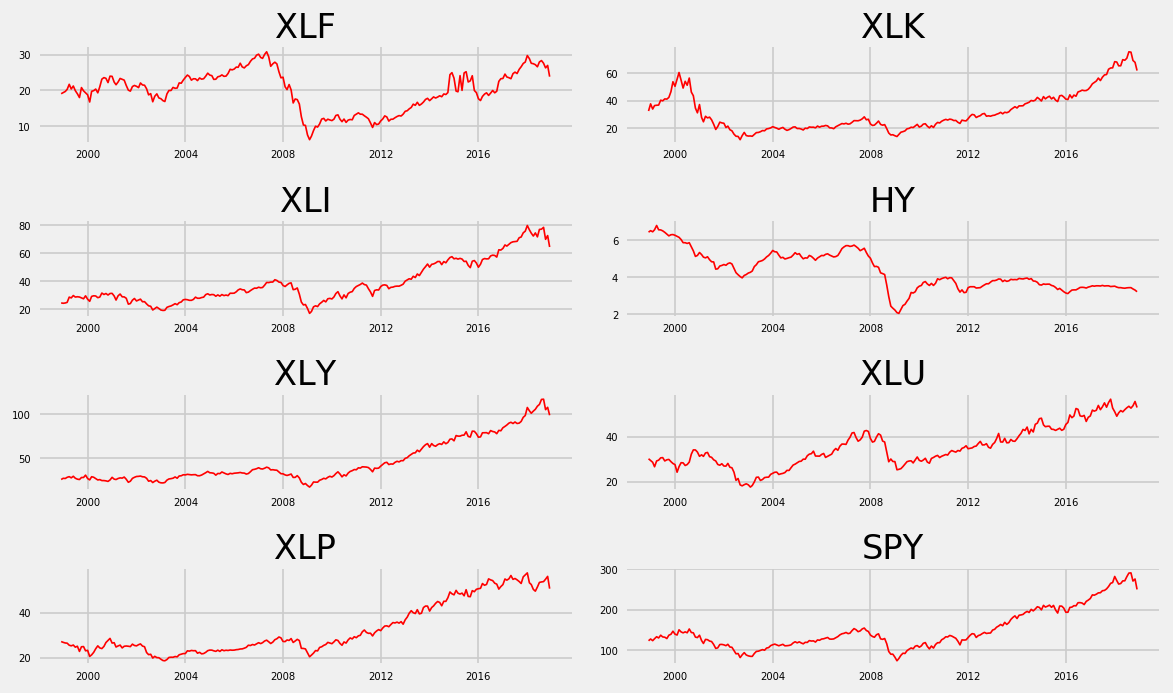

In [14]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [15]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)        

,XLF_x,XLK_x,XLI_x,HY_x,XLY_x,XLU_x,XLP_x,SPY_x,VBMFX_x
XLF_y,1.0000,0.1964,0.1022,0.0022,0.1409,0.3077,0.0031,0.0719,0.0659
XLK_y,0.0138,1.0000,0.0041,0.0727,0.0007,0.1416,0.0000,0.0003,0.0342
XLI_y,0.0002,0.2533,1.0000,0.0006,0.0070,0.3191,0.0001,0.0456,0.0053
HY_y,0.0291,0.1467,0.0294,1.0000,0.1211,0.0114,0.0026,0.1182,0.0051
XLY_y,0.0000,0.1337,0.0420,0.0001,1.0000,0.3603,0.0009,0.0291,0.0010
XLU_y,0.0965,0.0600,0.0010,0.0822,0.0050,1.0000,0.0399,0.0046,0.3801
XLP_y,0.0155,0.4049,0.0396,0.0425,0.3564,0.0002,1.0000,0.0716,0.0268
SPY_y,0.0003,0.1383,0.1540,0.0003,0.0028,0.2648,0.0000,1.0000,0.0032
VBMFX_y,0.0296,0.0107,0.1139,0.0001,0.0156,0.3332,0.6810,0.0176,1.0000


In [16]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
XLF    ::  257.3     > 179.5199  =>   True
XLK    ::  173.54    > 143.6691  =>   True
XLI    ::  108.6     > 111.7797  =>   False
HY     ::  64.34     > 83.9383   =>   False
XLY    ::  44.52     > 60.0627   =>   False
XLU    ::  28.06     > 40.1749   =>   False
XLP    ::  15.02     > 24.2761   =>   False
SPY    ::  5.87      > 12.3212   =>   False
VBMFX  ::  0.31      > 4.1296    =>   False


In [17]:
nobs = 36
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(205, 9)
(36, 9)


In [18]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [19]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "XLF" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.561
 No. Lags Chosen       = 3
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.5031. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "XLK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2472
 No. Lags Chosen       = 0
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.653. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "XLI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. N

In [20]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [21]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "XLF" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.898
 No. Lags Chosen       = 2
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "XLK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.6739
 No. Lags Chosen       = 0
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "XLI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [22]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -7.107339463177005
BIC :  -5.638430408429414
FPE :  0.0008196598020615692
HQIC:  -6.513077518315339 

Lag Order = 2
AIC :  -6.976372271935978
BIC :  -4.175809023145849
FPE :  0.0009383827522213612
HQIC:  -5.843259314402442 

Lag Order = 3
AIC :  -6.586140451349179
BIC :  -2.444683551693024
FPE :  0.0014021767107496262
HQIC:  -4.910327428142319 

Lag Order = 4
AIC :  -6.579417120755808
BIC :  -1.0877187054533284
FPE :  0.0014435821390181354
HQIC:  -4.3570107779247484 

Lag Order = 5
AIC :  -6.32984358060136
BIC :  0.5215543964636637
FPE :  0.001924161485032303
HQIC:  -3.556905776672494 

Lag Order = 6
AIC :  -6.146190275644747
BIC :  2.0744773010915907
FPE :  0.0024509329047932003
HQIC:  -2.818737281853405 

Lag Order = 7
AIC :  -6.115091836302202
BIC :  3.484529218281967
FPE :  0.0027524439292094284
HQIC:  -2.229093623335201 

Lag Order = 8
AIC :  -6.192670618878342
BIC :  4.795703519460687
FPE :  0.0028683766584591238
HQIC:  -1.744050129826169 

Lag Order = 9
AIC 

C:\Users\Aalok Devkota\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [26]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-7.253,-7.100*,0.0007080,-7.191*
1,-7.346*,-5.819,0.0006458*,-6.727
2,-7.307,-4.406,0.0006748,-6.132
3,-6.977,-2.701,0.0009512,-5.245
4,-6.936,-1.286,0.001016,-4.648
5,-6.595,0.4292,0.001489,-3.750
6,-6.350,2.049,0.002027,-2.948
7,-6.350,3.423,0.002218,-2.392
8,-6.439,4.707,0.002293,-1.925
9,-6.428,6.093,0.002735,-1.357


In [36]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Feb, 2020
Time:                     15:29:38
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -5.63843
Nobs:                     203.000    HQIC:                  -6.51308
Log likelihood:          -1781.01    FPE:                0.000819660
AIC:                     -7.10734    Det(Omega_mle):     0.000531718
--------------------------------------------------------------------
Results for equation XLF
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.042241         0.094432            0.447           0.655
L1.XLF          -0.100910         0.092084           -1.096           0.273
L1.XLK           0.037243         0.099533            0.374           0.708
L1.XLI

In [29]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

XLF : 1.96
XLK : 1.96
XLI : 1.98
HY : 1.94
XLY : 2.0
XLU : 2.0
XLP : 1.97
SPY : 1.97
VBMFX : 2.03


In [31]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ 0.32    , -1.02    , -1.580002, -0.11    , -0.720001,  0.510002,
        -0.120002, -7.529999,  0.04    ],
       [ 1.43    ,  4.150002,  4.560001,  0.06    ,  6.709999,  0.459999,
         2.7     , 17.259994, -0.02    ],
       [-4.12874 ,  0.309997,  0.470002, -0.09    , -0.190002, -0.93    ,
        -0.470001, -0.199997, -0.05    ],
       [-0.593014, -1.129997, -1.730004, -0.09    , -2.619995,  0.459999,
         1.070004, -4.820007, -0.07    ]])

In [39]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast.tail()

,XLF_2d,XLK_2d,XLI_2d,HY_2d,XLY_2d,XLU_2d,XLP_2d,SPY_2d,VBMFX_2d
Date,,,,,,,,,
2018-08-01,-0.001354,0.028278,0.139409,-0.016739,0.248322,0.065516,0.116064,0.372425,0.001925
2018-09-01,-0.001354,0.028278,0.139409,-0.016739,0.248322,0.065516,0.116064,0.372425,0.001925
2018-10-01,-0.001354,0.028278,0.139409,-0.016739,0.248322,0.065516,0.116064,0.372425,0.001925
2018-11-01,-0.001354,0.028278,0.139409,-0.016739,0.248322,0.065516,0.116064,0.372425,0.001925
2018-12-01,-0.001354,0.028278,0.139409,-0.016739,0.248322,0.065516,0.116064,0.372425,0.001925


In [33]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [42]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['XLF_forecast', 'XLK_forecast', 'XLI_forecast', 'HY_forecast',
                   'XLY_forecast', 'XLU_forecast', 'XLP_forecast', 'SPY_forecast', 'VBMFX_forecast']]

,XLF_forecast,XLK_forecast,XLI_forecast,HY_forecast,XLY_forecast,XLU_forecast,XLP_forecast,SPY_forecast,VBMFX_forecast
Date,,,,,,,,,
2016-01-01,18.750003,42.642936,51.556510,3.096988,76.243967,43.613913,51.445555,200.292526,10.596066
2016-02-01,18.108585,42.183136,50.206360,2.943805,74.487452,44.082640,52.505179,196.688733,10.550921
2016-03-01,17.451308,41.729496,48.953591,2.767657,72.928050,44.590575,53.697235,193.353469,10.509758
2016-04-01,16.781329,41.308610,47.837598,2.572548,71.614487,45.160376,54.997328,190.368350,10.471261
2016-05-01,16.107964,40.903908,46.855252,2.359443,70.541235,45.795390,56.413179,187.729660,10.434821
2016-06-01,15.431351,40.526248,46.010416,2.129075,69.714010,46.494869,57.945210,185.456549,10.400467
2016-07-01,14.752646,40.175643,45.304100,1.881728,69.133912,47.259571,59.592939,183.551646,10.368085
2016-08-01,14.072283,39.852738,44.736762,1.617530,68.801587,48.089656,61.356717,182.017401,10.337654
2016-09-01,13.390403,39.557892,44.308646,1.336543,68.717340,48.985184,63.236524,180.854777,10.309159


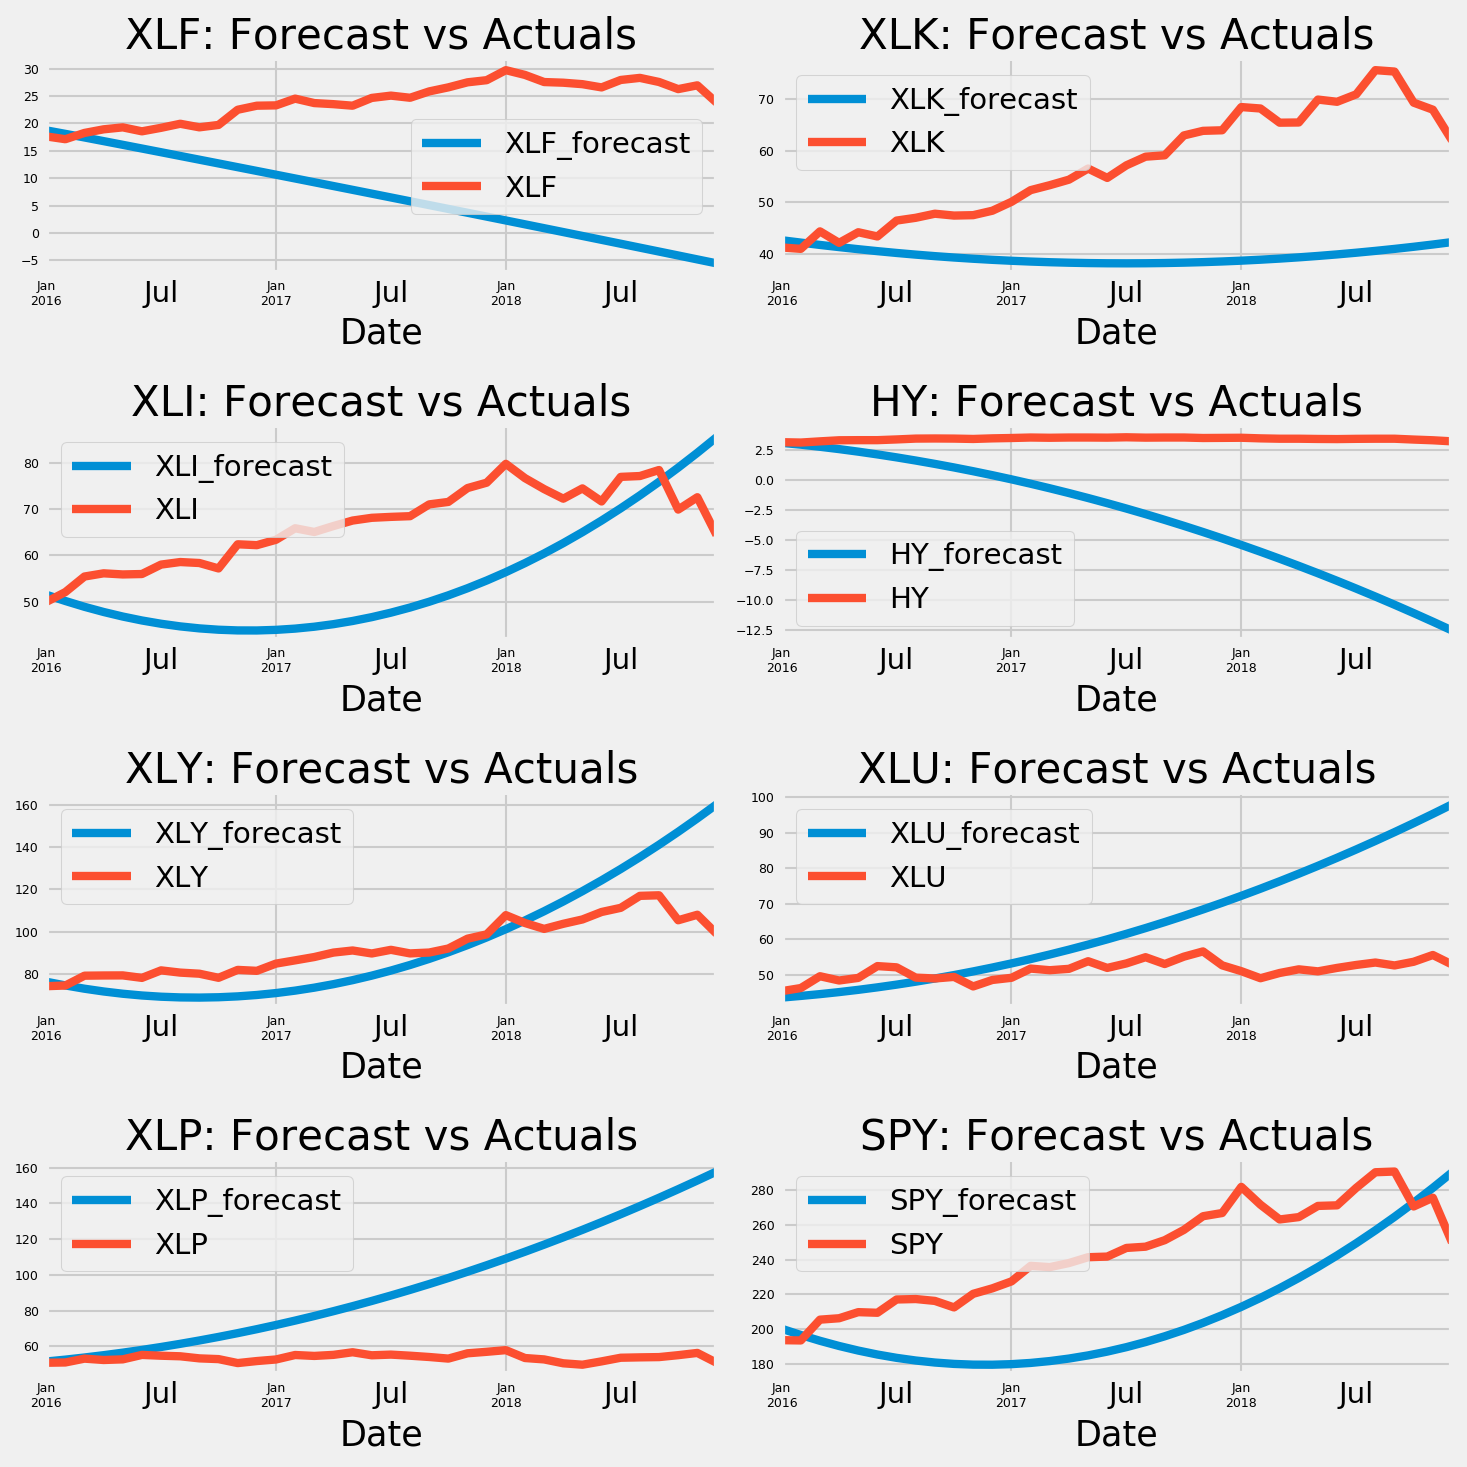

In [43]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [9]:
X = dataset2.drop('Class', 1)
y = dataset2['Class']

In [10]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.305399
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.472     
Dependent Variable: Class            AIC:              161.2024  
Date:               2020-02-21 19:02 BIC:              185.5960  
No. Observations:   241              Log-Likelihood:   -73.601   
Df Model:           6                LL-Null:          -139.49   
Df Residuals:       234              LLR p-value:      5.4330e-26
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
XLF        0.4260     0.0943    4.5201   0.0000    0.2413    0.6108
HY        -2.2166     0.5200   -4.2627   0.0000   -3.2358 

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\Aalok Devkota\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.8630


In [14]:
# Actual class predictions
logreg_predictions = logreg.predict(X_test)
# Probabilities for each class
logreg_probs = logreg.predict_proba(X_test)[:, 1]

logreg_probs_train = logreg.predict_proba(X_train)[:, 1]

from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, logreg_probs)
roc_value

0.9269565217391305

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[47  3]
 [ 7 16]]


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90        50
           1       0.84      0.70      0.76        23

    accuracy                           0.86        73
   macro avg       0.86      0.82      0.83        73
weighted avg       0.86      0.86      0.86        73



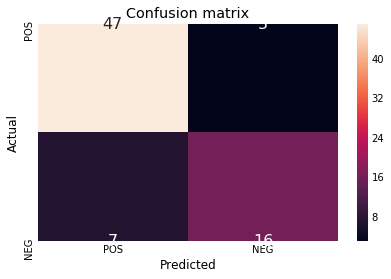

In [17]:
df_cm = pd.DataFrame(confusion_matrix, ['POS', 'NEG'], ['POS', 'NEG'])

sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g')

# sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
# # ax.xaxis.set_label_position("top")
# # plt.tight_layout()
plt.title('Confusion matrix', y=6.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

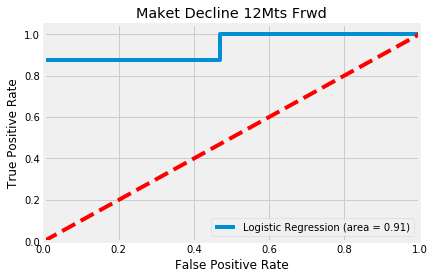

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Maket Decline 12Mts Frwd')
plt.legend(loc="lower right")

plt.show()

In [19]:
# X_test['Prob'] = logreg_probs.tolist()
# X_test

# frames = [dropped_values, X_test]

# result = pd.concat(frames, axis=1, sort=False)
# result

# result.to_csv(r'LR_Down_Results_42.csv')

In [20]:
new_dataset = pd.read_csv('data/DataToPredict.csv')
new_dataset
new_dataset2 = new_dataset.drop(['XLI','XLK','Date'],axis=1)
new_dataset2

,XLF,HY,XLY,XLU,XLP,SPY,VBMFX
0,25.940001,3.35,108.779999,54.759998,53.389999,269.929993,10.53
1,26.520000,3.39,110.209999,57.009998,54.340000,278.679993,10.50
2,25.709999,3.40,113.849998,58.169998,56.110001,282.480011,10.68
3,28.020000,3.43,120.070000,58.709999,57.709999,294.019989,10.66
4,26.010000,3.37,110.940002,58.250000,55.610001,275.269989,10.83
5,27.600000,3.43,119.199997,59.630001,58.070000,293.000000,10.93
6,28.250000,3.42,120.720001,59.549999,59.430000,297.429993,10.93
7,26.920000,3.43,119.580002,62.580002,60.720001,292.450012,11.21
8,28.000000,3.42,120.699997,64.739998,61.419998,296.769989,11.12
9,28.700001,3.43,120.849998,64.250000,61.160000,303.329987,11.12


In [21]:
predict_new_dataset = logreg.predict(new_dataset2)
predict_new_dataset

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
new_score = logreg.predict_proba(new_dataset2)[:, 1]
new_score

array([0.00074431, 0.00184239, 0.00053018, 0.0004247 , 0.00066621,
       0.00041089, 0.0008192 , 0.00039552, 0.00069624, 0.00220283,
       0.01517324, 0.01468651, 0.00621736, 0.00585866])

In [23]:
new_dataset['Prob'] = new_score.tolist()
newLogR_Down = pd.DataFrame(new_dataset)
newLogR_Down

,Date,XLF,XLK,XLI,HY,XLY,XLU,XLP,SPY,VBMFX,Prob
0,1/1/2019,25.940001,66.279999,71.769997,3.35,108.779999,54.759998,53.389999,269.929993,10.53,0.000744
1,2/1/2019,26.520000,70.860001,76.339996,3.39,110.209999,57.009998,54.340000,278.679993,10.50,0.001842
2,3/1/2019,25.709999,74.000000,75.029999,3.40,113.849998,58.169998,56.110001,282.480011,10.68,0.000530
3,4/1/2019,28.020000,78.709999,78.010002,3.43,120.070000,58.709999,57.709999,294.019989,10.66,0.000425
4,5/1/2019,26.010000,71.889999,72.050003,3.37,110.940002,58.250000,55.610001,275.269989,10.83,0.000666
5,6/1/2019,27.600000,78.040001,77.419998,3.43,119.199997,59.630001,58.070000,293.000000,10.93,0.000411
6,7/1/2019,28.250000,80.769997,77.820000,3.42,120.720001,59.549999,59.430000,297.429993,10.93,0.000819
7,8/1/2019,26.920000,79.529999,75.760002,3.43,119.580002,62.580002,60.720001,292.450012,11.21,0.000396
8,9/1/2019,28.000000,80.529999,77.629997,3.42,120.699997,64.739998,61.419998,296.769989,11.12,0.000696
9,10/1/2019,28.700001,83.669998,78.110001,3.43,120.849998,64.250000,61.160000,303.329987,11.12,0.002203


In [24]:
X_train['Prob'] = logreg_probs_train.tolist()
X_test

frames = [dropped_values, X_train]

result = pd.concat(frames, axis=1, sort=False)
result

result.to_csv(r'RF_DOWN_LR_ResultsTrain_42.csv')

C:\Users\Aalok Devkota\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
